#### Introduction as to why the notebook
Notebook created to work with redmond.json file and to check whether:  
1. There are any ways that are not connected to any other ways (single roads)
2. All the sidewalks are connected (Are there more than one component in the graph)
3. Find out the cardinality of the graph

In [78]:
import numpy as np
import os
import pandas as pd
import json
from glob import glob
import networkx as nx

#### Supporting functions for the main method

##### Get all the ways from the given input file
The input to this function is a list of features from the input file.  
Currently, we take all the features.  
This needs to **change** to only look at sidewalk data.

In [79]:
def get_ways(features_list):
    '''
    Returns a list of ways. Each way has a list of coordinates
    Outer list is the Ways
    Inner list is the coordinates pertaining to that way
    '''
    Ways = []
    for way in features_list:
        Ways.append(way['geometry']['coordinates'])
    return Ways

##### Make a dictionary of the coordinates and the ways in which they belong to
Helpful later for drawing the graph and to do analysis on top of it.

In [80]:
def get_coord_dict(coord_list):
    '''
    Returns dictionary of coordinate
    keys : unique coordinates
    values : ways to which the coord belongs
    '''
    coord_dict = dict()
    for id, elem in enumerate(coord_list):
        for point in elem:
            if(str(point) not in coord_dict.keys()):
                coord_dict[str(point)] = [id]
            else:
                coord_dict[str(point)].append(id)
    return coord_dict

In [81]:
def get_coord_df(coord_list):
    '''
    Return df with two columns: origin and dest
    ******** Note to Rakesh : This to be used for connected components in networkx
    '''
    data = {'origin':[], 'dest': []}
    df = pd.DataFrame(data)
    for elem in coord_list:
        # df = df.append([str(elem[0]), str(elem[-1])])
        df = df.append({'origin':str(elem[0]), 'dest':str(elem[-1])}, ignore_index=True)
    return df

##### Get discarded ways - ways that are not connected to any other way
The input to this function is a list of coordinates and the dictionary of coordinates.
The idea is to check  
- for a node in the list, check the length of the "value" of that _node_ as "key" in the dictionary
- if the length > 1, it means the node is present in at least 2 ways and this way is safe
- only if all the nodes in a way have length 1 in the dictionary, then it is not connected to any other way

In [82]:
def get_disc_way_ids(coord_list, coord_dict):
    '''
    Get way IDs to be discared (ways that are not part of any other ways)
    '''
    disc_way_ids = []
    for id, elem in enumerate(coord_list):
        ctr = 0
        for point in elem:
            if len(coord_dict[str(point)]) > 1:
                break
            else:
                ctr += 1
        if ctr == len(elem):
            disc_way_ids.append(id)
    return disc_way_ids

##### Get Way IDs from the subgraph - 
The input to this function is a subgraph and ways dataframe. Given a subgraph, we need to traceback to understand the ways this graph is made of. 

In [83]:
def get_way_from_subgraph(sgraph, df):
    '''
    Networkx gives subgraphs. This function is to infer the 'way id' from the given subgraph.
    Args : subgraph and df
    Retruns : set of ways that belong to subgraph
    '''   
    way_set = set()
    for ind, edge in enumerate(sgraph.edges):        
        #Coordinates can be interchanged between origin and dest. Hence checking both ways
        #either s1 or s2 gets a value which is index of the way from df, the given edge belongs to        
        s1 = pd.Series((df['origin'] == edge[-1]) & (df['dest'] == edge[0]))
        s2 = pd.Series((df['origin'] == edge[0]) & (df['dest'] == edge[-1]))        
        s = s1[s1].index.tolist() + s2[s2].index.tolist()
        way_set.update(s)        
    return list(way_set)

#### Main Function Steps
1. Get all the ways in the file
2. Check which ways are alone (Not connected to any other way) and separate them out
3. Of the remaining ways (that are connected to at least one another way), draw a graph
4. Check how many subgraphs (Components) are there in the whole network
5. Get the cardinality of the components (# of ways in those components and the way id)

In [84]:
if __name__ == '__main__':
    path = "E:\oswvalidators\OSW\TestData" # Change the path here to a relative one in the git folder structure
    os.chdir(path)
    json_files = glob("redmond.geojson")
    print("Number of json files :", len(json_files))
    
    for ind, file in enumerate(json_files):
        print('-'*10)
        print('Processing File : {}'.format(file))
        with open(file) as data_json:
            data_dict = json.load(data_json)
    
        Ways = get_ways(data_dict['features'])
        print("Number of ways in this file : ", len(Ways))
        
        coord_dict = get_coord_dict(Ways)
        #print("Coordinates Dictionary : \n", coord_dict)
        
        df = get_coord_df(Ways)
        #print("DataFrame : \n{}".format(df))
        
        disc_way_ids = get_disc_way_ids(Ways, coord_dict)
        #print(coord_dict.items())  
        #print("Number of isolated ways: ", len(disc_way_ids))

Number of json files : 1
----------
Processing File : redmond.geojson
Number of ways in this file :  8274


In [85]:
print("Number of isolated ways: ", len(disc_way_ids))

Number of isolated ways:  97


In [86]:
Connected_Ways = Ways.copy()
for x in sorted(disc_way_ids, reverse = True):  
    del Connected_Ways[x] 
    
#printing modified list
print("Number of ways in the file : ", len(Ways))
print("Number of isolated ways: ", len(disc_way_ids))
print("Number of Connected ways in the file : ", len(Connected_Ways))

Number of ways in the file :  8274
Number of isolated ways:  97
Number of Connected ways in the file :  8177


Connected_Ways now have all the ways that are connected to atleast one another way

In [87]:
Connected_df = get_coord_df(Connected_Ways)
Connected_FG = nx.from_pandas_edgelist(Connected_df, source='origin', target='dest')
print("Is the entire graph connected : ", nx.is_connected(Connected_FG))
print("Number of subgraphs : ", nx.number_connected_components(Connected_FG))
cc = nx.connected_components(Connected_FG)
for x in cc:
    print(len(x))

Is the entire graph connected :  False
Number of subgraphs :  70
6493
9
8
4
2
12
3
17
15
21
11
30
6
8
8
9
42
6
6
5
11
5
8
5
3
12
4
6
8
4
6
4
4
9
32
7
3
6
5
4
4
4
6
4
4
6
6
4
5
4
4
4
6
20
4
3
7
5
3
6
3
5
7
5
3
12
3
3
4
3


In [90]:
S = [Connected_FG.subgraph(c).copy() for c in nx.connected_components(Connected_FG)]

In [91]:
print(S[2].edges)

[('[-122.1225776, 47.6609811]', '[-122.1212387, 47.660692]'), ('[-122.1210514, 47.6606568]', '[-122.1212387, 47.660692]'), ('[-122.1210514, 47.6606568]', '[-122.1198851, 47.6604996]'), ('[-122.1210514, 47.6606568]', '[-122.1210514, 47.6606568]'), ('[-122.1197987, 47.6604993]', '[-122.1195921, 47.6601282]'), ('[-122.1197987, 47.6604993]', '[-122.1197386, 47.6606554]'), ('[-122.1197987, 47.6604993]', '[-122.1198851, 47.6604996]'), ('[-122.1200033, 47.6608091]', '[-122.1200033, 47.6608091]'), ('[-122.1200033, 47.6608091]', '[-122.1198851, 47.6604996]')]


Given a subgraph, get the way IDs

In [96]:
way_set = get_way_from_subgraph(S[1], Connected_df)
print(way_set)

[1255, 1256, 1257, 1258, 1259, 1262, 1263, 1264, 1265, 18, 19]


In [75]:
cc = nx.connected_components(Connected_FG)
for ind, x in enumerate(cc):
    print("{}\n:{}".format(ind,x))

0
:{'[-122.1342211, 47.6405986]', '[-122.1423069, 47.6443615]', '[-122.1294204, 47.635299]', '[-122.1359116, 47.637857]', '[-122.1399634, 47.6600885]', '[-122.1333457, 47.6415108]', '[-122.124795, 47.6426478]', '[-122.1371107, 47.6455219]', '[-122.1252815, 47.6386519]', '[-122.132166, 47.6461932]', '[-122.1268013, 47.6440455]', '[-122.1375662, 47.6422825]', '[-122.1331588, 47.6520414]', '[-122.1371708, 47.6451859]', '[-122.1410419, 47.641957]', '[-122.1255076, 47.6461491]', '[-122.1404395, 47.6450923]', '[-122.1373295, 47.6606777]', '[-122.1404648, 47.6390263]', '[-122.1376602, 47.6459112]', '[-122.1383025, 47.6481654]', '[-122.126908, 47.645023]', '[-122.1346079, 47.6508961]', '[-122.1375626, 47.642142]', '[-122.1321604, 47.635942]', '[-122.1265909, 47.6386502]', '[-122.1361361, 47.6396209]', '[-122.1329608, 47.6367551]', '[-122.1413578, 47.63922]', '[-122.1408103, 47.6396104]', '[-122.1403513, 47.6494165]', '[-122.1421949, 47.6510803]', '[-122.1412873, 47.6449903]', '[-122.1249683, 4

#### Analysis data

##### Number of coordinates in ways

In [76]:
Coordinates_in_ways = []
for x in range(0,len(Ways)):
    Coordinates_in_ways.append(len(Ways[x]))
freq = {} 
for item in Coordinates_in_ways: 
    if (item in freq): 
        freq[item] += 1
    else: 
        freq[item] = 1

for key, value in freq.items(): 
    print ("% d : % d"%(key, value)) 

 7 :  144
 2 :  5483
 4 :  561
 3 :  1071
 6 :  215
 1 :  28
 5 :  300
 10 :  57
 19 :  6
 9 :  73
 8 :  127
 22 :  5
 13 :  24
 11 :  52
 15 :  16
 12 :  20
 17 :  12
 14 :  28
 16 :  13
 38 :  2
 27 :  1
 26 :  2
 25 :  3
 29 :  1
 24 :  2
 31 :  1
 23 :  1
 20 :  7
 32 :  3
 18 :  6
 39 :  1
 28 :  1
 36 :  1
 82 :  1
 110 :  1
 21 :  3
 52 :  1
 50 :  1


##### Number of ways at a coordinate

In [77]:
ways_at_coordinates = []
for x in coord_dict:
    ways_at_coordinates.append((len(coord_dict[x])))
ways_at_coordinates
freq = {} 
for item in ways_at_coordinates: 
    if (item in freq): 
        freq[item] += 1
    else: 
        freq[item] = 1

for key, value in freq.items(): 
    print ("% d : % d"%(key, value)) 

 1 :  11228
 2 :  2477
 4 :  756
 3 :  2260
 5 :  9
 6 :  3


##### Discard this - not needed.
This is to encode the nodes to a numeric value for drawing the graph using Networkx
Created to overcome a simple error while drawing graph using networkx  
_Edge_attr = True_ does not need to be present. 

In [138]:
ddata = {'origin':[], 'dest': [], 'source':[], 'destination':[]}
ddf = pd.DataFrame(ddata)
Encoding = {}
n = 0
src_val, dest_val = 0,0
for elem in range(0,len(Ways)):
    
    if (str(Ways[elem][0]) not in Encoding.keys()):
        Encoding[str(Ways[elem][0])] = n
        src_val = n
        n = n+1
    else:
        src_val = Encoding[str(Ways[elem][0])]
    
    if (str(Ways[elem][-1]) not in Encoding.keys()):
        Encoding[str(Ways[elem][-1])] = n
        dest_val = n
        n = n+1
    else:
        dest_val = Encoding[str(Ways[elem][-1])]
    
    ddf = ddf.append({'origin':str(Ways[elem][0]), 'dest':str(Ways[elem][-1]), 'source':src_val, 'destination':dest_val}, ignore_index=True)
#type(Ways)
ddf

,origin,dest,source,destination
0,"[-122.1223606, 47.6497991]","[-122.1229443, 47.6493146]",0.0,1.0
1,"[-122.123659, 47.6426983]","[-122.1236183, 47.6426538]",2.0,3.0
2,"[-122.1236183, 47.6426538]","[-122.1232496, 47.6422501]",3.0,4.0
3,"[-122.1429074, 47.6443656]","[-122.1428099, 47.6443612]",5.0,6.0
4,"[-122.1428099, 47.6443612]","[-122.1424519, 47.6443185]",6.0,7.0
...,...,...,...,...
8269,"[-122.1283874, 47.6445091]","[-122.1284344, 47.6442655]",6098.0,7199.0
8270,"[-122.1296765, 47.6434206]","[-122.1296762, 47.6434487]",7201.0,7202.0
8271,"[-122.1296762, 47.6434487]","[-122.1293391, 47.6434494]",7202.0,6185.0
8272,"[-122.1299943, 47.6433744]","[-122.1300266, 47.6433966]",7203.0,6163.0


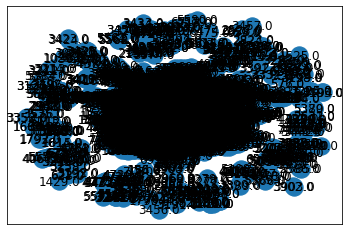

In [139]:
import networkx as nx
FG = nx.from_pandas_edgelist(ddf, source='source', target='destination', edge_attr=True)
nx.draw_networkx(FG, with_labels=True)

In [ ]:
print(nx.is_connected(FG))
print(nx.number_connected_components(FG))
cc = nx.connected_components(FG)
#for x in cc:
    #print(x)
    #print(len(x))